# Modeling and Evaluation

## 1. Notebook Overview

This notebook builds, tunes, and evaluates machine learning models for employee attrition prediction using the cleaned dataset and the saved preprocessing pipeline from the previous notebook.

The focus here is on interpretability. Logistic Regression is used as the primary model because it's straightforward to explain and interpret, making it the perfect choice for understanding what factors most strongly influence attrition.

Specifically, this notebook:

- Loads the cleaned dataset (`data_01.csv`)
- Loads the saved preprocessing pipeline (`preprocessing_pipeline.pkl`)
- Applies the transformations defined during preprocessing via the pipeline (feature engineering, encoding, scaling)
- Trains and evaluates a Logistic Regression classifier
- Assesses performance using both cross-validation and test set metrics
- Interprets results using explainability techniques to highlight drivers of attrition

In [1]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

## 2. Load Dataset and Preprocessing Pipeline

- Load `data_01.csv` (unaltered clean dataset)
- Load `preprocessing_pipeline.pkl` using `joblib`
- Confirm compatibility and inspect sample rows

In [2]:
# Load dataset and preprocessing pipeline

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()
        return self

    def transform(self, X):
        df = X.copy()

        df['TenureCategory'] = pd.cut(
            df['YearsAtCompany'],
            bins=[-1, 2, 5, 10, np.inf],
            labels=['<3 yrs', '3–5 yrs', '6–10 yrs', '10+ yrs']
        )

        df['YearsAtCompanyRatio'] = df['YearsAtCompany'] / df['TotalWorkingYears'].replace(0, np.nan)
        df['YearsInRoleRatio'] = df['YearsInCurrentRole'] / df['YearsAtCompany'].replace(0, np.nan)
        df['YearsWithManagerRatio'] = df['YearsWithCurrManager'] / df['YearsAtCompany'].replace(0, np.nan)
        df['IncomePerYear'] = df['MonthlyIncome'] / df['YearsAtCompany'].replace(0, np.nan)

        df['ZeroCompanyTenureFlag'] = (df['YearsAtCompany'] == 0).astype(int)
        df['NoWorkHistoryFlag'] = ((df['YearsAtCompany'] == 0) & (df['TotalWorkingYears'] == 0)).astype(int)

        df['JobRoleGroup'] = df['JobRole'].replace({
            'Laboratory Technician': 'Technical',
            'Research Scientist': 'Technical',
            'Healthcare Representative': 'Sales',
            'Sales Executive': 'Sales',
            'Sales Representative': 'Sales'
        })

        df['SatisfactionAvg'] = df[['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']].mean(axis=1)
        df['SatisfactionRange'] = (
            df[['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']].max(axis=1)
            - df[['EnvironmentSatisfaction', 'JobSatisfaction', 'RelationshipSatisfaction']].min(axis=1)
        )

        df['LowSatisfactionFlag'] = (
            (df['EnvironmentSatisfaction'] <= 2)
            | (df['JobSatisfaction'] <= 2)
            | (df['RelationshipSatisfaction'] <= 2)
        ).astype(int)

        df['OverTime_JobLevel'] = df['OverTime'].astype(str) + "_" + df['JobLevel'].astype(str)
        df['Travel_Occupation'] = df['BusinessTravel'].astype(str) + "_" + df['JobRole'].astype(str)

        df['StressRisk'] = (
            (df['OverTime'] == 'Yes')
            & (df['LowSatisfactionFlag'] == 1)
            & (df['SatisfactionAvg'] < 2.5)
        ).astype(int)

        return df

# Load clean input data
df = pd.read_csv('../data/processed/data_01.csv')

# Load saved pipeline with full preprocessing and feature engineering
preprocessing_pipeline = joblib.load('../models/preprocessing_pipeline.pkl')

# Sanity check structure
print("Shape of data_01.csv:", df.shape)
display(df.head())

# Compatibility test: Run partial transform
try:
    preprocessing_pipeline.transform(df.drop(columns='Attrition').head(3))
    print("Pipeline is compatible with current data")
except Exception as e:
    print("Pipeline check failed.")
    import traceback
    traceback.print_exc()

Shape of data_01.csv: (1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


Pipeline is compatible with current data


## 3. Train-Test Split

- Separate features (`X`) and target (`y`)
- Perform stratified train-test split (preserving class distribution)
- Reserve test set exclusively for final evaluation

Train shape: (1176, 30), Test shape: (294, 30)

Target distribution in training set:
Attrition
No     0.838
Yes    0.162
Name: proportion, dtype: float64

Target distribution in test set:
Attrition
No     0.84
Yes    0.16
Name: proportion, dtype: float64


C:\Users\justi\AppData\Local\Temp\ipykernel_20400\2165430433.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='pastel')
C:\Users\justi\AppData\Local\Temp\ipykernel_20400\2165430433.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=axes[1], palette='pastel')


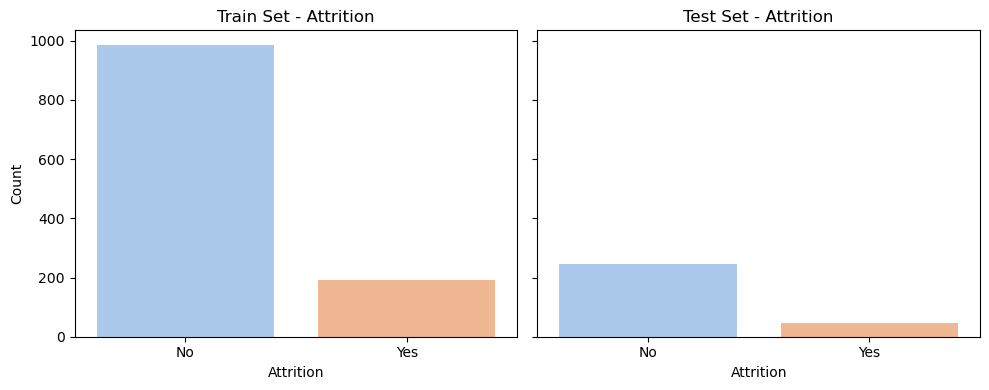

In [3]:
# Separate features and target
X = df.drop(columns='Attrition')
y = df['Attrition']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Restore column names
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Fit preprocessing pipeline (includes FeatureEngineer)
preprocessing_pipeline.fit(X_train)

# Basic shape check
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Class balance check
print("\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))

print("\nTarget distribution in test set:")
print(y_test.value_counts(normalize=True).round(3))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.countplot(x=y_train, ax=axes[0], palette='pastel')
axes[0].set_title("Train Set - Attrition")
axes[0].set_xlabel("Attrition")
axes[0].set_ylabel("Count")

sns.countplot(x=y_test, ax=axes[1], palette='pastel')
axes[1].set_title("Test Set - Attrition")
axes[1].set_xlabel("Attrition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [4]:
# Optional column alignment check
print("x_train columns:", X_train.columns.tolist())
print("Missing in x_train:", set(preprocessing_pipeline.named_steps['features'].feature_names_in_) - set(X_train.columns))
print("Extra in x_train:", set(X_train.columns) - set(preprocessing_pipeline.named_steps['features'].feature_names_in_))

x_train columns: ['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Missing in x_train: set()
Extra in x_train: set()


## 5. Cross-Validation and Hyperparameter Tuning

- Use `GridSearchCV` or `Optuna` to tune model hyperparameters
- Train and cross-validate on the full training set
- Evaluate model performance using cross-validation metrics
- Save the best-performing model pipeline

In [5]:
print(X_train.columns.tolist())

['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [6]:
print(X_train.value_counts())

Age  BusinessTravel     DailyRate  Department              DistanceFromHome  Education  EducationField    EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  JobRole                JobSatisfaction  MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked  OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager
60   Travel_Rarely      1179       Sales                   16                4          Marketing         1                        Male    84          3               2         Sales Executive        1                Single         5405           11924        8                   No        14                 3                  4                         0                 10                 1                      3                2               2                   2                   

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1194 to 1292
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1176 non-null   int64 
 1   BusinessTravel            1176 non-null   object
 2   DailyRate                 1176 non-null   int64 
 3   Department                1176 non-null   object
 4   DistanceFromHome          1176 non-null   int64 
 5   Education                 1176 non-null   int64 
 6   EducationField            1176 non-null   object
 7   EnvironmentSatisfaction   1176 non-null   int64 
 8   Gender                    1176 non-null   object
 9   HourlyRate                1176 non-null   int64 
 10  JobInvolvement            1176 non-null   int64 
 11  JobLevel                  1176 non-null   int64 
 12  JobRole                   1176 non-null   object
 13  JobSatisfaction           1176 non-null   int64 
 14  MaritalStatus             

In [8]:
# Append model to preprocessing pipeline
model_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Grid search space
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on raw training data (NOT transformed!)
grid_search.fit(X_train, y_train)

# Save best model pipeline
joblib.dump(grid_search.best_estimator_, '../models/final_model_pipeline.pkl')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


['../models/final_model_pipeline.pkl']

## 6. Final Model Evaluation on Test Set

- Predict on the untouched test set
- Evaluate with metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - ROC-AUC
- Plot confusion matrix and ROC curve

## 7. Model Explainability

- Apply SHAP and/or LIME for feature attribution
- Visualize global feature importance
- Analyze individual predictions and edge cases
- Identify key drivers of attrition risk

## 8. Business Insights and Final Summary

- Summarize key model performance findings
- Highlight most impactful features influencing attrition
- Provide actionable recommendations
- Suggest next steps for model deployment or refinement